In [4]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name']
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [5]:
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_268cc603_337a_40c4_b72e_6832de48f4cf',
  'project_id':'bda8761f527d4105b5a75a73ffff34cb',
  'region':'dallas',
  'user_id':'7ec29220ca394bada27616523efb53c8',
  'domain_id':'a398474a5f52452cbe1eaff93ed7dc24',
  'domain_name':'979599',
  'username':'Admin_283d80ac127d2d3b2b22c237b74006ff580c546d',
  'password':"""g=4R4t6p^uGB!?5b""",
  'filename':'NYPD_Motor_Vehicle_Collisions.csv',
  'container':'notebooks',
  'tenantId':'s2a6-7d0b2dc50b9e35-13f3cf96cd59'
}

In [6]:
credentials['name'] = 'keystone'
set_hadoop_config(credentials)

In [9]:
from __future__ import division
import numpy as np

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# adding the PySpark modul to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

collisions = sc.textFile("swift://" + credentials['container'] + "." + credentials['name'] + "/NYPD_Motor_Vehicle_Collisions.csv")

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

collisions_header = collisions.first()


collisions_header_list = collisions_header.split(",")
collisions_body = collisions.mapPartitionsWithIndex(skip_header)

# filter not valid rows
collisions_body = collisions_body.filter(lambda line : len(line.split(","))>29)

# create Spark DataFrame using pyspark-csv
collisions_df = pycsv.csvToDataFrame(sqlContext, collisions_body, sep=",", columns=collisions_header_list)
collisions_df.cache()

DataFrame[DATE: timestamp, TIME: timestamp, BOROUGH: string, ZIP CODE: int, LATITUDE: double, LONGITUDE: double, LOCATION: string, ON STREET NAME: string, CROSS STREET NAME: string, OFF STREET NAME: string, NUMBER OF PERSONS INJURED: int, NUMBER OF PERSONS KILLED: int, NUMBER OF PEDESTRIANS INJURED: int, NUMBER OF PEDESTRIANS KILLED: int, NUMBER OF CYCLIST INJURED: int, NUMBER OF CYCLIST KILLED: int, NUMBER OF MOTORIST INJURED: int, NUMBER OF MOTORIST KILLED: int, CONTRIBUTING FACTOR VEHICLE 1: string, CONTRIBUTING FACTOR VEHICLE 2: string, CONTRIBUTING FACTOR VEHICLE 3: string, CONTRIBUTING FACTOR VEHICLE 4: string, CONTRIBUTING FACTOR VEHICLE 5: string, UNIQUE KEY: int, VEHICLE TYPE CODE 1: string, VEHICLE TYPE CODE 2: string, VEHICLE TYPE CODE 3: string, VEHICLE TYPE CODE 4: string, VEHICLE TYPE CODE 5: string]

In [10]:
collisions_df.printSchema()

root
 |-- DATE: timestamp (nullable = true)
 |-- TIME: timestamp (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: integer (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: integer (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: integer (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string 

In [11]:

collisions_df.take(1)

[Row(DATE=datetime.datetime(2016, 5, 24, 0, 0), TIME=datetime.datetime(2016, 7, 6, 13, 10), BOROUGH=u'BRONX', ZIP CODE=10468, LATITUDE=40.8749033, LONGITUDE=-73.9012885, LOCATION=u'(40.8749033, -73.9012885)', ON STREET NAME=None, CROSS STREET NAME=None, OFF STREET NAME=u'2893 SEDGWICK AVENUE', NUMBER OF PERSONS INJURED=0, NUMBER OF PERSONS KILLED=0, NUMBER OF PEDESTRIANS INJURED=0, NUMBER OF PEDESTRIANS KILLED=0, NUMBER OF CYCLIST INJURED=0, NUMBER OF CYCLIST KILLED=0, NUMBER OF MOTORIST INJURED=0, NUMBER OF MOTORIST KILLED=0, CONTRIBUTING FACTOR VEHICLE 1=u'Unspecified', CONTRIBUTING FACTOR VEHICLE 2=u'Unspecified', CONTRIBUTING FACTOR VEHICLE 3=None, CONTRIBUTING FACTOR VEHICLE 4=None, CONTRIBUTING FACTOR VEHICLE 5=None, UNIQUE KEY=3445895, VEHICLE TYPE CODE 1=u'PASSENGER VEHICLE', VEHICLE TYPE CODE 2=u'PASSENGER VEHICLE', VEHICLE TYPE CODE 3=None, VEHICLE TYPE CODE 4=None, VEHICLE TYPE CODE 5=None)]

In [12]:
collisions_df.count()

697710

In [25]:
!pip install --user seaborn

You are using pip version 7.1.0, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 159kB 1.9MB/s 
  Running setup.py install for seaborn


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

import seaborn as sns
import pandas as pd

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [14]:
collisions_pd = collisions_df[collisions_df['LATITUDE'] != 0][['LATITUDE', 'LONGITUDE', 'DATE', 'TIME',
                                                               'BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME',
                                                               'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                                                               'CONTRIBUTING FACTOR VEHICLE 1']].toPandas()

collisions_pd.columns = ['Latitude', 'Longitude', 'Date', 'Time', 'Borough', 'On Street',
                         'Cross Street', 'Persons Injured', 'Persons Killed', 'Contributing Factor']

#divide dataset in accidents which are: fatal, non-lethal but with person damage, non of the above
killed_pd = collisions_pd[collisions_pd['Persons Killed']!=0]
injured_pd = collisions_pd[np.logical_and(collisions_pd['Persons Injured']!=0, collisions_pd['Persons Killed']==0)]
nothing_pd = collisions_pd[np.logical_and(collisions_pd['Persons Killed']==0, collisions_pd['Persons Injured']==0)]

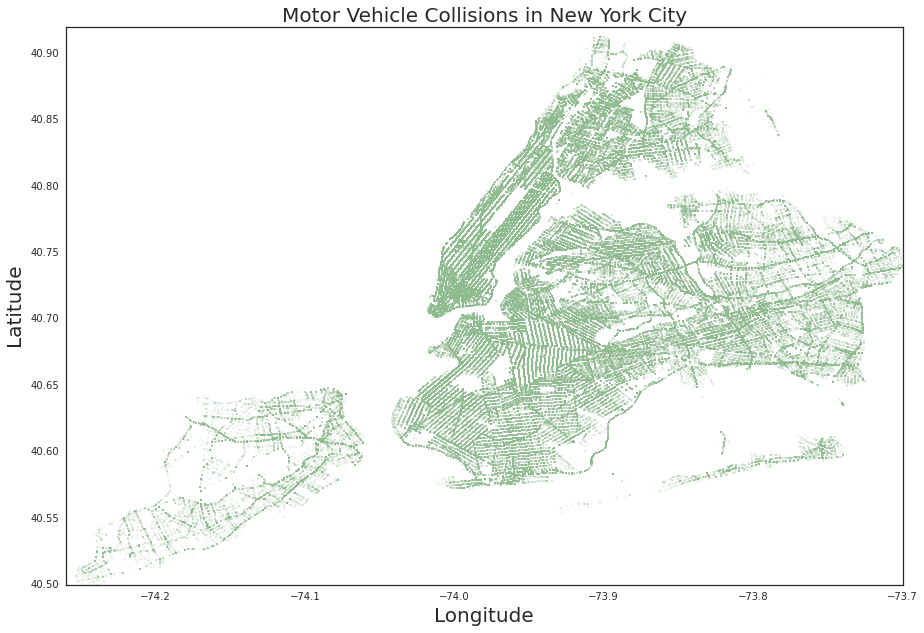

In [31]:
#adjust settings
sns.set_style("white")
plt.figure(figsize=(15,10))

#create scatterplots
plt.scatter(collisions_pd.Longitude, collisions_pd.Latitude, alpha=0.05, s=4, color='darkseagreen')

#adjust more settings
plt.title('Motor Vehicle Collisions in New York City', size=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)

plt.show()

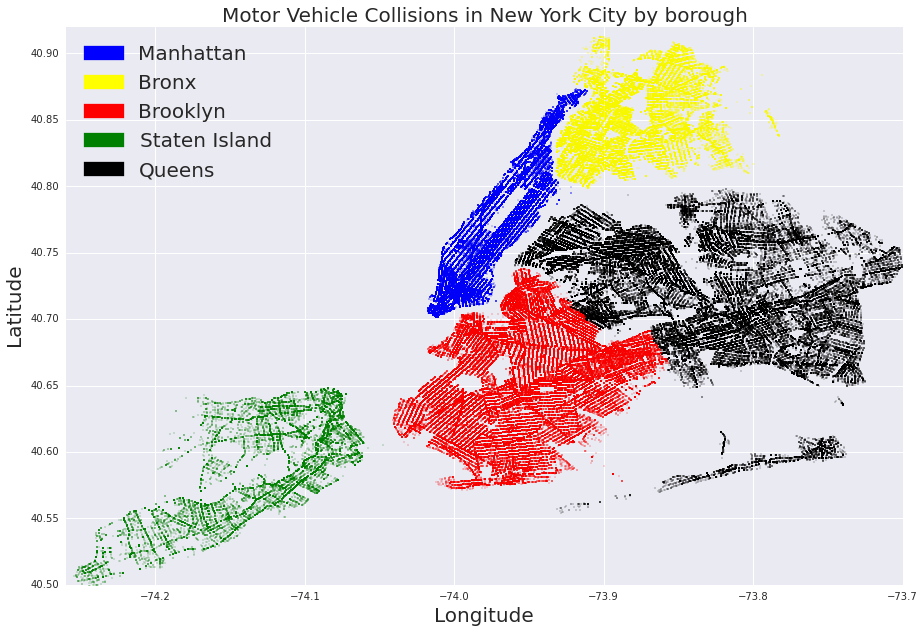

In [17]:
manhattan = collisions_pd[collisions_pd['Borough']=='MANHATTAN']
bronx = collisions_pd[collisions_pd['Borough']=='BRONX']
brooklyn = collisions_pd[collisions_pd['Borough']=='BROOKLYN']
staten = collisions_pd[collisions_pd['Borough']=='STATEN ISLAND']
queens = collisions_pd[collisions_pd['Borough']=='QUEENS']

plt.figure(figsize=(15,10), dpi=0.1)

#create scatterplots
plt.scatter(manhattan.Longitude, manhattan.Latitude, s=1, color='blue', marker ='.')
plt.scatter(bronx.Longitude, bronx.Latitude, s=1, color='yellow', marker ='.')
plt.scatter(brooklyn.Longitude, brooklyn.Latitude, color='red', s=1, marker ='.')
plt.scatter(staten.Longitude, staten.Latitude, s=1, color='green', marker ='.')
plt.scatter(queens.Longitude, queens.Latitude, s=1, color='black', marker ='.')

#create legend
blue_patch = mpatches.Patch(label='Manhattan', color='blue')
yellow_patch = mpatches.Patch(color='yellow', label='Bronx')
red_patch = mpatches.Patch(color='red', label='Brooklyn')
green_patch = mpatches.Patch(color='green', label='Staten Island')
black_patch = mpatches.Patch(color='black', label='Queens')
plt.legend([blue_patch, yellow_patch, red_patch, green_patch, black_patch],
           ('Manhattan', 'Bronx', 'Brooklyn', 'Staten Island', 'Queens'),
           loc='upper left', prop={'size':20})

#adjust more settings
plt.title('Motor Vehicle Collisions in New York City by borough', size=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

In [18]:
borough = collisions_df.groupBy('BOROUGH').count().sort('count').toPandas()
colors = ['g','0.75','y','k','b','r']
plt.barh(range(6),borough.sort_values(by='count', ascending=True)['count'], color=colors)
plt.xlabel('Collisions')
plt.ylabel('Borough')
plt.title('Total Number of Collisions by Borough', size=15)
plt.yticks(range(6), borough['BOROUGH'])
plt.show()

AttributeError: 'DataFrame' object has no attribute 'sort_values'

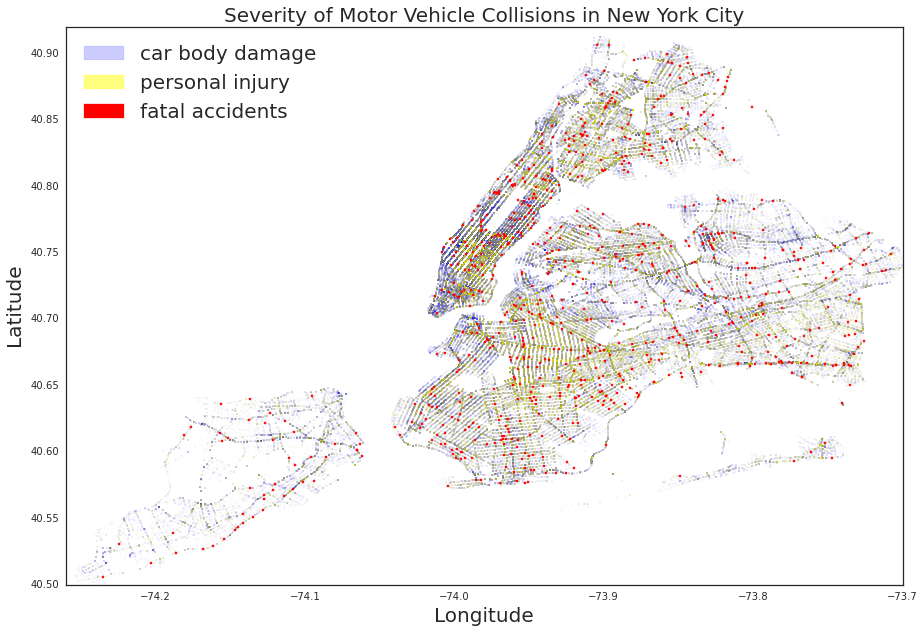

In [34]:
#adjust settings
plt.figure(figsize=(15,10))

#create scatterplots
plt.scatter(nothing_pd.Longitude, nothing_pd.Latitude, alpha=0.04, s=1, color='blue')
plt.scatter(injured_pd.Longitude, injured_pd.Latitude, alpha=0.1, s=1, color='yellow')
plt.scatter(killed_pd.Longitude, killed_pd.Latitude, color='red', s=5)

#create legend
blue_patch = mpatches.Patch( label='car body damage', alpha=0.2, color='blue')
yellow_patch = mpatches.Patch(color='yellow', label='personal injury', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='lethal accidents')
plt.legend([blue_patch, yellow_patch, red_patch],('car body damage', 'personal injury', 'fatal accidents'),
           loc='upper left', prop={'size':20})

#adjust more settings
plt.title('Severity of Motor Vehicle Collisions in New York City', size=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.savefig('anothertry.png')

plt.show()

In [ ]:
#clean and shape the data
collisions_header_list

In [36]:
#gain information on street and borough

collisions_df = collisions_df.dropna(how='any', subset=['ON STREET NAME', 'BOROUGH'])
collisions_df.count()

610218

In [19]:
# Define new schema
collisions_out_row = pyspark.sql.Row(*(["Time", "Street", "Borough"] + [c for c in collisions_header_list
                      if c not in ["ON STREET NAME", "OFF STREET NAME", "CROSS STREET NAME", "BOROUGH", "DATE", "TIME"]]))
collisions_out_index = list(collisions_out_row)

collisions_out = collisions_df.map(
    lambda row: collisions_out_row(*(get_temporal(row) + get_spatial(row) + get_rest(row))))

def get_spatial(row):
    """
    Computes the location identifier from the input row

    Returns:
        List of spatial key columns
    """
    loc = normalize_street(row.asDict()['ON STREET NAME'])
    borough = row.asDict()['BOROUGH'].lower()
    return [loc, borough]


def get_temporal(row):
    """
    Computes the temporal key from a given row
    """
    from datetime import datetime
    return [datetime(row.DATE.year, row.DATE.month, row.DATE.day, row.TIME.hour)]


def get_rest(row):
    """
    Computes the rest from a given row
    """
    return [row.asDict()[column] for column in collisions_header_list
             if column not in ["ON STREET NAME", "OFF STREET NAME", "CROSS STREET NAME", "BOROUGH", "DATE", "TIME"]]

delchars = ''.join(c for c in map(chr, range(256)) if not c.isalnum())

deltable = dict((ord(char), None) for char in delchars) # Python2 unicode

normalization_code = {
    'avenue':'av',
    'ave':'av',
    'avnue': 'av',
    'street': 'st',
    'road': 'rd',
    'boulevard': 'blvd',
    'place': 'pl',
    'plaza': 'pl',
    'square': 'sq',
    'drive': 'dr',
    'lane': 'ln',
    'parkway': 'pkwy',
    'turnpike': 'tp',
    'terrace': 'ter',
    '1st': '1',
    '2nd':'2',
    '3rd': '3',
    '1th': '1',
    '2th': '2',
    '3th': '3',
    '4th': '4',
    '5th': '5',
    '6th': '6',
    '7th': '7',
    '8th': '8',
    '9th': '9',
    '0th': '0',
    'west ': 'w ',
    'north ': 'n ',
    'east ': 'e ',
    'south ': 's ',
}

def normalize_street(s):
    # Lowercase
    s = s.lower()

    # Delete all non-alphanumeric characters
    if isinstance(s, unicode):
        s = s.translate(deltable)
    else:
        s = s.translate(None, delchars) # Python 2

    # Replace common abbreviations
    for k in sorted(normalization_code.keys()):
        s = s.replace(k, normalization_code[k])

    # Only keep ascii chars
    s = s.encode('ascii', errors='ignore').decode()

    return s

In [22]:
from pyspark.sql.functions import desc

collisions_out_df = collisions_out.toDF(sampleRatio=1)

factor = collisions_out_df.groupBy('CONTRIBUTING FACTOR VEHICLE 1').count().sort(desc('count')).toPandas()
factor = factor[0:24].sort_index(ascending=False)
factor.plot(kind='barh', legend=False, color='blue', figsize=(14,10))
plt.title('Composition of: ' + 'CONTRIBUTING FACTOR VEHICLE 1', size=20)
plt.xlabel('Count')
plt.yticks(range(len(factor))[::-1], factor['CONTRIBUTING FACTOR VEHICLE 1'][::-1])
plt.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 12.0 failed 10 times, most recent failure: Lost task 0.9 in stage 12.0 (TID 449, yp-spark-dal09-env5-0026): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 1293, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-19-8e2a648b0222>", line 7, in <lambda>
  File "<ipython-input-19-8e2a648b0222>", line 16, in get_spatial
  File "<ipython-input-19-8e2a648b0222>", line 76, in normalize_street
AttributeError: 'NoneType' object has no attribute 'lower'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.lang.Thread.run(Thread.java:785)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at java.lang.Thread.getStackTrace(Thread.java:1117)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1837)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1850)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1863)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:95)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:55)
	at java.lang.reflect.Method.invoke(Method.java:507)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:785)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 1293, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-19-8e2a648b0222>", line 7, in <lambda>
  File "<ipython-input-19-8e2a648b0222>", line 16, in get_spatial
  File "<ipython-input-19-8e2a648b0222>", line 76, in normalize_street
AttributeError: 'NoneType' object has no attribute 'lower'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [21]:
from collections import Counter

vehicletypecode, vehicletypecoderange = 'VEHICLE TYPE CODE ', range(1,6)
grouping = {
    'TAXI': 'Taxi',
    'AMBULANCE': 'Other',
    'BICYCLE': 'Other',
    'BUS': 'Bus',
    'FIRE TRUCK': 'Other',
    'LARGE COM VEH(6 OR MORE TIRES)': 'Truck',
    'LIVERY VEHICLE': 'Truck',
    'MOTORCYCLE': 'Other',
    'OTHER': 'Other',
    'PASSENGER VEHICLE': 'Auto',
    'PICK-UP TRUCK': 'Other',
    'PEDICAB': 'Other',
    'SCOOTER': 'Other',
    'SMALL COM VEH(4 TIRES)': 'Truck',
    'SPORT UTILITY / STATION WAGON': 'Auto',
    'UNKNOWN': 'Other',
    'VAN': 'Auto',
    'UNSPECIFIED': 'Other',
    None: None
}

collisions_out_categories = collisions_out.map(lambda row:
                   collisions_out_row(*[grouping[row[i]] if collisions_out_index[i].startswith("VEHICLE TYPE CODE")
                                                    else row[i] for i in range(len(row))])
                  )

In [23]:
collisions_transformed_row = pyspark.sql.Row(*(["Time", "Street", "Borough", "Injured",
                                                "Killed", "Auto", "Bus",
                                                "Truck", "Taxi", "Other", ]))

def transform_involved(row):
    counts = Counter([row[i] for i in range(len(row)) if collisions_out_index[i].startswith("VEHICLE TYPE CODE")])

    return collisions_transformed_row(*([row.asDict()[c] for c in ["Time", "Street", "Borough",
                                                                      "NUMBER OF PERSONS INJURED",
                                                                      "NUMBER OF PERSONS KILLED"]] +
                                       [counts[x] if x in counts else 0
                                           for x in ['Auto', 'Bus','Truck', 'Taxi', 'Other']]))

collisions_transformed = collisions_out_categories.map(transform_involved)

In [24]:

collisions_transformed_boolean_row = pyspark.sql.Row(*(["Time", "Street", "Borough",
                                                        "AccidentsWithInjuries",
                                                        "AccidentswithDeaths", "Auto", "Bus",
                                                        "Truck", "Taxi", "Other",
                                                        "Injured", "Killed"]))

collisions_transformed_boolean = collisions_transformed.map(
    lambda row: collisions_transformed_boolean_row(*([int(row.asDict()[c] > 0) if c in ["Injured",
                                                "Killed"] else row.asDict()[c]
                                                      for c in list(collisions_transformed_row)] +
                                                    [row.Injured, row.Killed])))

In [26]:
aggregation_columns = {x:"sum" for x in ["AccidentsWithInjuries", "AccidentswithDeaths",
                                    "Auto", "Bus", "Truck", "Taxi", "Other", "Injured", "Killed"]}
aggregation_columns.update({"*":"count"})

collisions_grouped = collisions_transformed_boolean.toDF().groupBy(
    "Time", "Street", "Borough").agg(aggregation_columns)

# rename columns names
for c in collisions_grouped.columns:
    if c.startswith("sum") or c.startswith("SUM"):
        collisions_grouped = collisions_grouped.withColumnRenamed(c, c[4:-1])
    elif c.startswith("count") or c.startswith("COUNT"):
        collisions_grouped = collisions_grouped.withColumnRenamed(c, "NumberOfAccidents")

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 14.0 failed 10 times, most recent failure: Lost task 0.9 in stage 14.0 (TID 469, yp-spark-dal09-env5-0026): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 1293, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-19-8e2a648b0222>", line 7, in <lambda>
  File "<ipython-input-19-8e2a648b0222>", line 16, in get_spatial
  File "<ipython-input-19-8e2a648b0222>", line 76, in normalize_street
AttributeError: 'NoneType' object has no attribute 'lower'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.lang.Thread.run(Thread.java:785)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at java.lang.Thread.getStackTrace(Thread.java:1117)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1837)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1850)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1863)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:95)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:55)
	at java.lang.reflect.Method.invoke(Method.java:507)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:785)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 1293, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-19-8e2a648b0222>", line 7, in <lambda>
  File "<ipython-input-19-8e2a648b0222>", line 16, in get_spatial
  File "<ipython-input-19-8e2a648b0222>", line 76, in normalize_street
AttributeError: 'NoneType' object has no attribute 'lower'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [27]:

collisions_final_row = pyspark.sql.Row(*(["Year", "Month", "Day", "Hour"] + collisions_grouped.columns[1:]))
collisions_final = collisions_grouped.map(lambda row: collisions_final_row(*([row.Time.year, row.Time.month,
                                                                              row.Time.day, row.Time.hour] +
                                                                             [row.asDict()[x]
                                                                              for x in collisions_final_row[4:]])))

NameError: name 'collisions_grouped' is not defined

In [28]:
from pyspark.sql import functions as F
collisions_final_df = collisions_final.toDF()
plottingdf = collisions_final_df.groupBy("Borough", "Street").agg(F.sum("NumberOfAccidents").alias("sum(NumberOfAccidents)")).\
sort(F.desc('sum(NumberOfAccidents)')).limit(10).toPandas()
plottingdf[['sum(NumberOfAccidents)']].plot(kind='barh', figsize=(11,7), legend=False)
plt.title('Top 10 Streets with the most accidents', size=20)
plt.xlabel('Count')
plt.yticks(range(10), plottingdf['Street'])
plt.gca().invert_yaxis()
plt.show()

NameError: name 'collisions_final' is not defined

In [29]:
from pyspark.sql import functions as F

hourplot = collisions_final_df[['Bus','Truck','Taxi','Other','Hour','Auto']].groupBy('Hour')\
.agg(F.sum("Bus").alias("Bus"), F.sum("Truck").alias("Truck"), F.sum("Taxi").alias("Taxi"),\
F.sum("Other").alias("Other"),F.sum("Auto").alias("Auto")).toPandas()

hourplot[['Bus', 'Truck', 'Taxi', 'Auto']].plot(stacked=True, kind='bar',figsize=(12,8), alpha=1)
#'SUM(Other)',
plt.xlabel('Hours in a Day', size=17)
plt.ylabel('Vehicles', size=17)
plt.legend(loc='best', prop={'size':20}, framealpha=0)
plt.title('Collisions on Road per Hour', size=25)
plt.show()

NameError: name 'collisions_final_df' is not defined